<a href="https://colab.research.google.com/github/claudio1975/PyDataVenice/blob/main/STForecast_CP_NVIDIA_eow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Prepare workspace

In [1]:
!pip install -U statsforecast==2.0.2 &>/dev/null

In [2]:
!pip install yfinance==0.2.65 &>/dev/null

In [3]:
# Yahoo Finance API
# ==============================================================================
import yfinance as yf

In [4]:
# Handling and processing of Data
# ==============================================================================
import numpy as np
import pandas as pd
import scipy.stats as stats

# Handling and processing of Data for Date (time)
# ==============================================================================
import datetime
import time
from datetime import datetime, timedelta

# Statistics and plots
# ==============================================================================
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [5]:
# Statistical Models
# ==============================================================================
from statsforecast import StatsForecast
from statsforecast.models import SeasonalExponentialSmoothing, ARIMA, AutoARIMA
from statsforecast.utils import ConformalIntervals
from sklearn.metrics import mean_squared_error


In [6]:
# Plot
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import matplotlib.dates as mdates
from utilsforecast.plotting import plot_series


In [7]:
# Utils
# ==============================================================================
import re
import warnings
warnings.filterwarnings("ignore")


### Data

In [8]:
stock_ticker = yf.Ticker("NVDA")
stock_history = stock_ticker.history(period="5y")
stock_history.head(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-10-26 00:00:00-04:00,13.386136,13.651077,12.998818,13.101255,336896000,0.0,0.0
2020-10-27 00:00:00-04:00,13.265505,13.401092,13.151354,13.355980,250520000,0.0,0.0
2020-10-28 00:00:00-04:00,13.157833,13.219644,12.570626,12.588571,376520000,0.0,0.0
2020-10-29 00:00:00-04:00,12.799427,13.152599,12.711196,12.984363,320080000,0.0,0.0
2020-10-30 00:00:00-04:00,12.810894,12.897130,12.262567,12.495855,416820000,0.0,0.0
2020-11-02 00:00:00-05:00,12.619229,12.797684,12.357279,12.542463,299652000,0.0,0.0
2020-11-03 00:00:00-05:00,12.669825,13.065118,12.564397,12.979878,272900000,0.0,0.0
2020-11-04 00:00:00-05:00,13.348501,13.785417,13.296410,13.752268,410228000,0.0,0.0
2020-11-05 00:00:00-05:00,14.119398,14.295360,13.948420,14.116905,319028000,0.0,0.0


In [9]:
df = stock_history.copy()

# Reset the index
df.reset_index(inplace=True)

# Ensure Date is a datetime object and format it
df['Date'] = pd.to_datetime(df['Date'])

# Select the necessary columns
df = df[['Date', 'Close']]

# Rename the 'Date' column to 'ds'
df = df.rename(columns={'Date': 'ds','Close':'y'})

df["unique_id"] = "1"
df.columns=["ds", "y", "unique_id"]

# Now df should have the index reset, Date formatted, and renamed to 'ds'
df.head()

,ds,y,unique_id
0,2020-10-26 00:00:00-04:00,13.101255,1
1,2020-10-27 00:00:00-04:00,13.355980,1
2,2020-10-28 00:00:00-04:00,12.588571,1
3,2020-10-29 00:00:00-04:00,12.984363,1
4,2020-10-30 00:00:00-04:00,12.495855,1


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1256 entries, 0 to 1255
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype                           
---  ------     --------------  -----                           
 0   ds         1256 non-null   datetime64[ns, America/New_York]
 1   y          1256 non-null   float64                         
 2   unique_id  1256 non-null   object                          
dtypes: datetime64[ns, America/New_York](1), float64(1), object(1)
memory usage: 29.6+ KB


In [11]:
test_size=63

In [12]:
train=df.iloc[:-test_size]
test=df.iloc[-test_size:]


In [13]:
train.shape, test.shape

((1193, 3), (63, 3))

In [14]:
print(train.min())
print(train.max())

ds           2020-10-26 00:00:00-04:00
y                            11.213529
unique_id                            1
dtype: object
ds           2025-07-28 00:00:00-04:00
y                           176.740036
unique_id                            1
dtype: object


In [15]:
print(test.min())
print(test.max())

ds           2025-07-29 00:00:00-04:00
y                            167.01059
unique_id                            1
dtype: object
ds           2025-10-24 00:00:00-04:00
y                           192.570007
unique_id                            1
dtype: object


### Functions

In [16]:
def rename_forecast_columns(df):
    """
    Rename forecast columns to 'y_hat', 'y_hat_lower', and 'y_hat_upper'
    regardless of the estimator name or prediction interval.

    Parameters:
    df (pd.DataFrame): The DataFrame containing forecast results.

    Returns:
    pd.DataFrame: DataFrame with renamed columns.
    """
    new_columns = {}
    for col in df.columns:
        if col == 'y':
            # Keep the actual values column unchanged
            continue
        elif col == 'ds':
            # Keep the actual values column unchanged
            continue
        elif col == 'unique_id':
            # Keep the actual values column unchanged
            continue
        elif re.search(r'-lo-\d+', col):
            # Rename lower prediction interval
            new_columns[col] = 'y_hat_lower'
        elif re.search(r'-hi-\d+', col):
            # Rename upper prediction interval
            new_columns[col] = 'y_hat_upper'
        else:
            # Rename the predicted value
            new_columns[col] = 'y_hat'

    # Apply the renaming
    df = df.rename(columns=new_columns)
    return df

In [17]:
def calculate_rmse(predictions, targets):
    """
    Calculate Root Mean Squared Error between predictions and targets.
    """
    return np.sqrt(mean_squared_error(targets, predictions))

In [18]:
def evaluate_metrics_with_boundaries(df):
    # RMSE for Point Predictions
    rmse = calculate_rmse(df['y_hat'], df['y'])

    # RMSE for Lower Boundary
    rmse_lo = calculate_rmse(df['y_hat_lower'], df['y'])

    # RMSE for Upper Boundary
    rmse_hi = calculate_rmse(df['y_hat_upper'], df['y'])

    # Coverage
    coverage = ((df['y'] >= df['y_hat_lower']) &
                (df['y'] <= df['y_hat_upper'])).mean()

    # Average Width of Prediction Intervals
    average_width = (df['y_hat_upper'] - df['y_hat_lower']).mean()


    metrics = {
        'RMSE_Point': rmse,
        'RMSE_Lower_Bound': rmse_lo,
        'RMSE_Upper_Bound': rmse_hi,
        'Coverage (%)': coverage * 100,
        'Average Width': average_width
    }

    return metrics



In [19]:
def forecast_vis(train, test, prediction, ticker):
  # Reset index to ensure 'ds' is a column
  train_df = train.reset_index()
  test_df = test_result.reset_index()
  prediction_df = prediction_result.reset_index()

  # Convert 'ds' to datetime if not already
  train_df['ds'] = pd.to_datetime(train_df['ds'])
  test_df['ds'] = pd.to_datetime(test_df['ds'])
  prediction_df['ds'] = pd.to_datetime(prediction_df['ds'])

  plt.figure(figsize=(16, 8))

  # Plot Training Data
  plt.plot(train_df['ds'], train_df['y'], label='Train Actual', color='black', linewidth=2)

  # Plot Test Data Actual
  plt.plot(test_df['ds'], test_df['y'], label='Test Actual', color='blue', linewidth=2)


  # Plot Test Predictions with PIs
  plt.plot(test_df['ds'], test_df['y_hat'], label='Test Prediction', color='orange', linewidth=2)
  plt.fill_between(test_df['ds'], test_df['y_hat_lower'], test_df['y_hat_upper'],
                 color='orange', alpha=0.2, label='Test Prediction Interval')

  # Plot Future Predictions with PIs
  plt.plot(prediction_df['ds'], prediction_df['y_hat'], label='Future Prediction', color='green', linewidth=2)
  plt.fill_between(prediction_df['ds'], prediction_df['y_hat_lower'], prediction_df['y_hat_upper'],
                 color='green', alpha=0.2, label='Future Prediction Interval')

  # Formatting the plot
  plt.xlabel('Date', fontsize=14)
  plt.ylabel('Value', fontsize=14)
  plt.title(f'Forecasting Results {ticker}', fontsize=16)
  plt.legend(fontsize=12)
  plt.grid(True, which='both', linestyle='--', linewidth=0.5)

  # Improve date formatting on x-axis
  plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
  plt.gca().xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))

  plt.tight_layout()
  plt.show()

In [20]:
def forecast_vis2(test, prediction, ticker):

  # Reset index to ensure 'ds' is a column (if not already)
  test_df = test_result.reset_index(drop=True)
  prediction_df = prediction_result.reset_index(drop=True)

  # Convert 'ds' to datetime if not already
  test_df['ds'] = pd.to_datetime(test_df['ds'])
  prediction_df['ds'] = pd.to_datetime(prediction_df['ds'])

  # Initialize the plot
  plt.figure(figsize=(16, 8))

  # Plot Test Actual Values
  plt.plot(test_df['ds'], test_df['y'], label='Test Actual', color='blue', linewidth=2)

  # Plot Test Predictions
  plt.plot(test_df['ds'], test_df['y_hat'], label='Test Prediction', color='orange', linewidth=2)

  # Fill PIs for Test Predictions
  plt.fill_between(test_df['ds'], test_df['y_hat_lower'], test_df['y_hat_upper'],
                 color='orange', alpha=0.2, label='Test Prediction Interval')

  # Plot Future Predictions
  plt.plot(prediction_df['ds'], prediction_df['y_hat'], label='Future Prediction', color='green', linewidth=2)

  # Fill PIs for Future Predictions
  plt.fill_between(prediction_df['ds'], prediction_df['y_hat_lower'], prediction_df['y_hat_upper'],
                 color='green', alpha=0.2, label='Future Prediction Interval')

  # Customize the Plot
  plt.xlabel('Date', fontsize=14)
  plt.ylabel('Value', fontsize=14)
  plt.title(f'Test and Future Conformal Prediction Results {ticker}', fontsize=16)
  plt.legend(fontsize=12)
  plt.grid(True, which='both', linestyle='--', linewidth=0.5)

  # Format the x-axis for better readability
  plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
  plt.gca().xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))

  plt.tight_layout()
  plt.show()

### Modelling

In [21]:
# Initializing and Fitting the Model
horizon=84
# Define prediction intervals
intervals = ConformalIntervals(h=horizon, n_windows=4)

# Define the models
models1 = [
    AutoARIMA(prediction_intervals=intervals),
]

# Initialize StatsForecast with daily business frequency
sf = StatsForecast(models=models1, freq='B', n_jobs=-1)

# Fit the model
sf.fit(train)


StatsForecast(models=[AutoARIMA])

In [22]:
# Define coverage for prediction intervals
levels = [95]  # 95% PIs

# Perform forecasting
forecast_df = sf.predict(h=horizon, level=levels)
forecast_df=rename_forecast_columns(forecast_df)

In [23]:
# prediction of test set and the next business period
test_max_date = test['ds'].max()
test_forecast = forecast_df[forecast_df['ds'] <= test_max_date]
# Merge the DataFrames on 'unique_id' and 'ds'
test_result = pd.merge(
    test_forecast,
    test,
    on=['unique_id','ds'],
    how='left'
)

# Optionally handle missing values
test_result= test_result.dropna()

prediction_result = forecast_df[forecast_df['ds'] > test_max_date]

In [24]:
# Calculate Metrics
test_metrics = evaluate_metrics_with_boundaries(test_result)

# Display Metrics
print(f"Test metrics:")
for key, value in test_metrics.items():
    print(f"{key}: {value:.4f}")

Test metrics:
RMSE_Point: 5.0688
RMSE_Lower_Bound: 24.6855
RMSE_Upper_Bound: 27.4755
Coverage (%): 100.0000
Average Width: 48.6092


In [25]:
test_result.head()

,unique_id,ds,y_hat,y_hat_lower,y_hat_upper,y
0,1,2025-07-29 00:00:00-04:00,176.676586,173.895194,179.457977,175.500092
1,1,2025-07-30 00:00:00-04:00,176.971480,172.104987,181.837974,179.259903
2,1,2025-07-31 00:00:00-04:00,176.982677,166.642583,187.322772,177.859970
3,1,2025-08-01 00:00:00-04:00,177.218475,165.776180,188.660769,173.710205
4,1,2025-08-04 00:00:00-04:00,177.276458,165.727932,188.824985,179.989853


In [26]:
prediction_result.head()

,unique_id,ds,y_hat,y_hat_lower,y_hat_upper
64,1,2025-10-27 00:00:00-04:00,185.504401,140.611443,230.397358
65,1,2025-10-28 00:00:00-04:00,185.640955,145.262939,226.018970
66,1,2025-10-29 00:00:00-04:00,185.777508,135.510583,236.044433
67,1,2025-10-30 00:00:00-04:00,185.914062,136.633162,235.194962
68,1,2025-10-31 00:00:00-04:00,186.050616,137.802568,234.298664


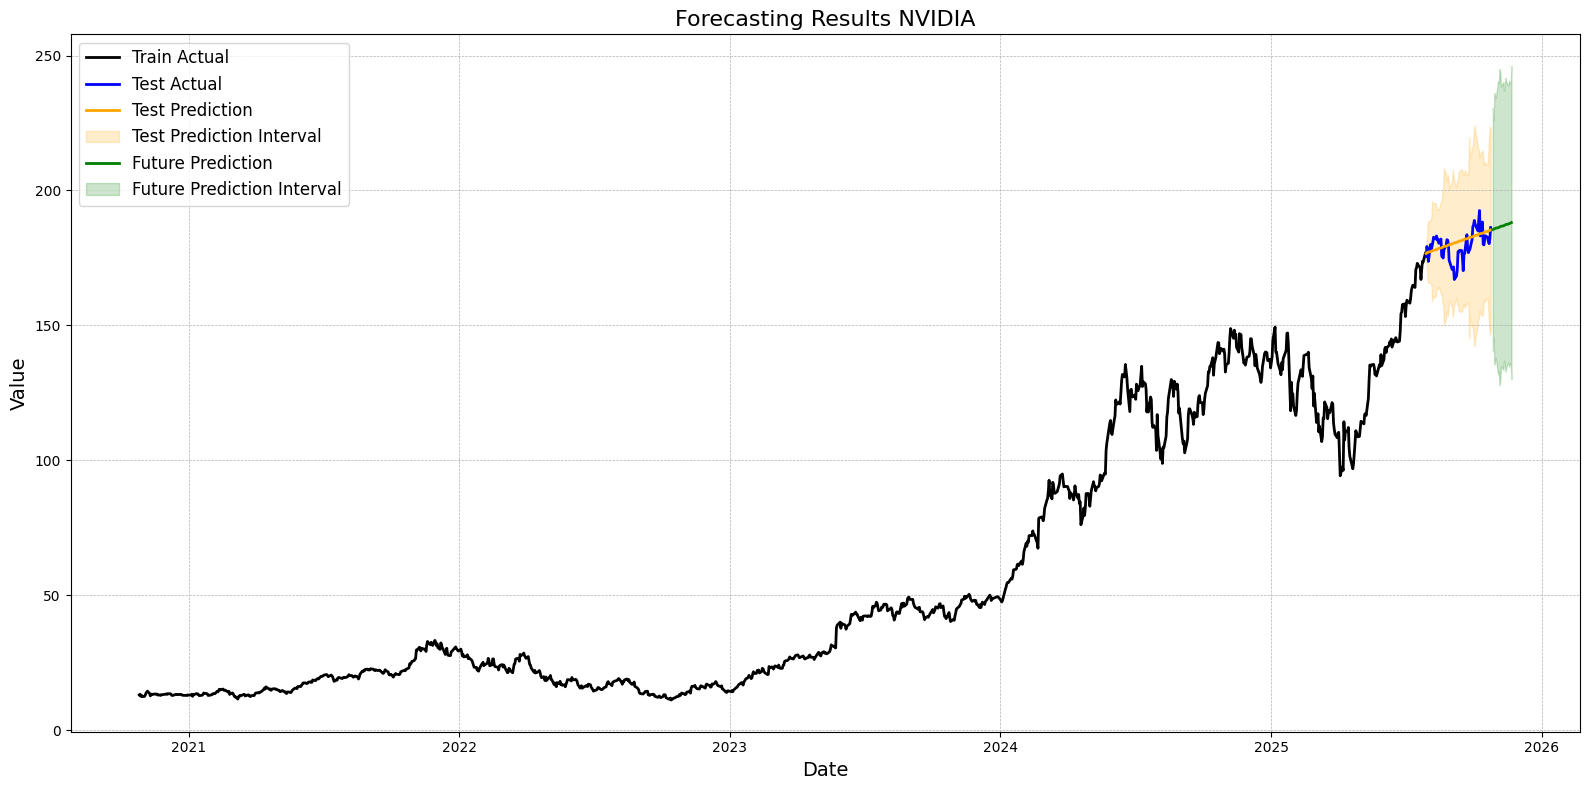

In [27]:
forecast_vis(train,test_result,prediction_result,'NVIDIA')

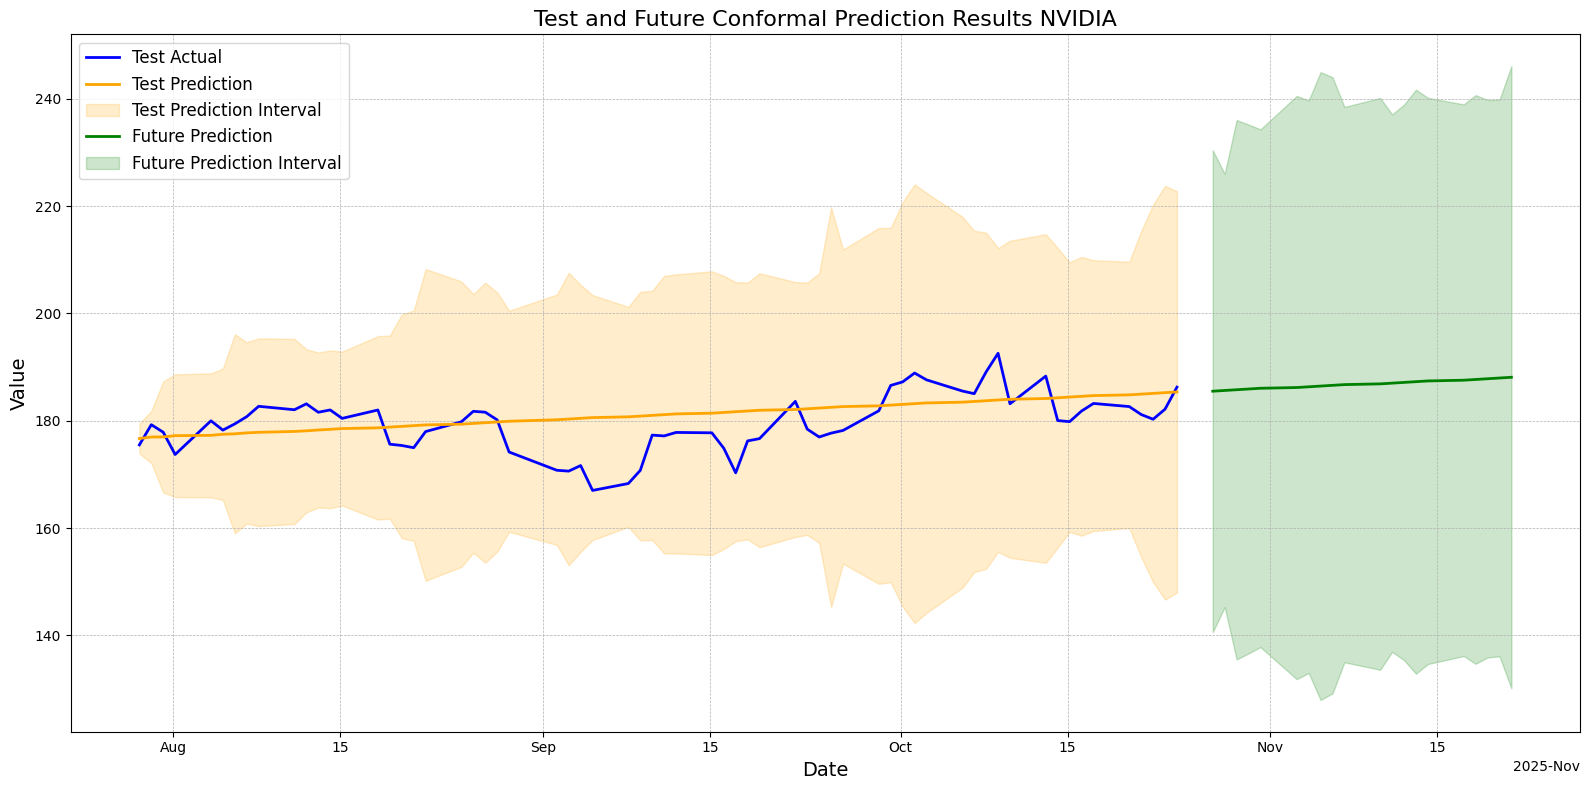

In [28]:
forecast_vis2(test_result, prediction_result,'NVIDIA')

### Prediction Price

In [29]:
actual_price=df.iloc[-1]
forecast_price=prediction_result.iloc[-1]

actual_date = pd.to_datetime(actual_price['ds']).strftime('%d-%m-%Y')
forecast_date = pd.to_datetime(forecast_price['ds']).strftime('%d-%m-%Y')

print(f"At the evaluation date of {actual_date} the stock price is {actual_price['y']}")
print(f"At the forecasting date of {forecast_date} the stock price is {forecast_price['y_hat']}")


At the evaluation date of 24-10-2025 the stock price is 186.25999450683594
At the forecasting date of 21-11-2025 the stock price is 188.09892192796724


### Backtesting

In [30]:
cv= sf.cross_validation(
    df=train,
    h=1,
    n_windows=3,
    fitted=True
)
cv_result= sf.cross_validation_fitted_values()

In [31]:
# Calculate RMSE per fold
rmse_per_fold = cv_result.groupby('cutoff').apply(lambda x: calculate_rmse(x['y'], x['AutoARIMA']))
rmse_per_fold = rmse_per_fold.rename('RMSE')

# Convert to DataFrame and reset index
rmse_df = rmse_per_fold.reset_index(drop=True).to_frame()

# Add a 'Fold' column
rmse_df['Fold'] = range(0, len(rmse_df))

# Set 'Fold' as the index
rmse_df.set_index('Fold', inplace=True)

# Display the results
print("RMSE per CV Fold:")
print(rmse_df)

# Calculate and display average RMSE across all folds
average_rmse = rmse_df['RMSE'].mean()
print(f"\nAverage CV RMSE across all folds: {average_rmse:.4f}")

RMSE per CV Fold:
          RMSE
Fold          
0     2.316701
1     2.317993
2     2.317088

Average CV RMSE across all folds: 2.3173


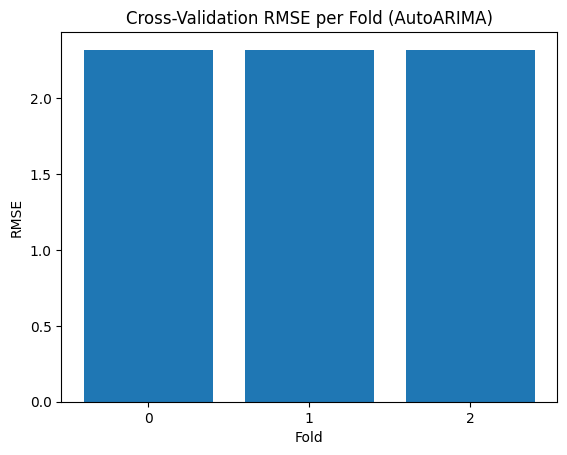

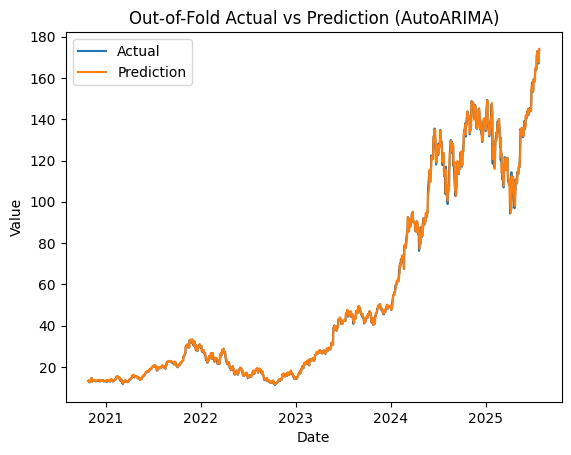

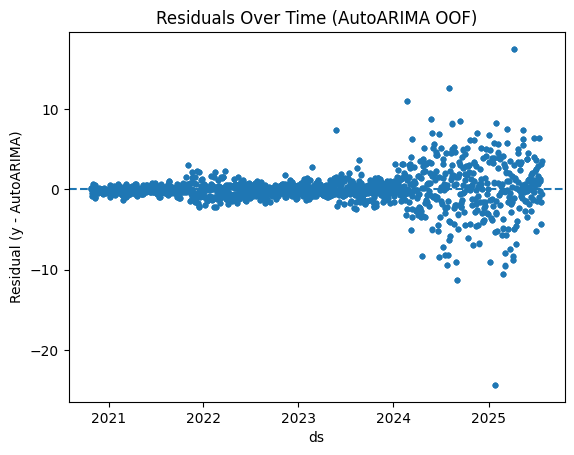

Average CV RMSE across all folds: 2.3173


In [32]:
# === Plots for Cross-Validation Backtesting (AutoARIMA) ===
# 1) Bar chart of RMSE per fold
# 2) Line plot of Actual vs Prediction over time (OOF)
# 3) Scatter plot of residuals over time


# 1) RMSE per fold (bar chart)

plt.figure()
plt.bar(rmse_df.index.astype(str), rmse_df["RMSE"])
plt.xlabel("Fold")
plt.ylabel("RMSE")
plt.title("Cross-Validation RMSE per Fold (AutoARIMA)")
plt.show()

# 2) Actual vs Prediction over time (line plot)
cv_sorted = cv_result.sort_values(by="ds").reset_index(drop=True)

plt.figure()
plt.plot(cv_sorted["ds"], cv_sorted["y"], label="Actual")
plt.plot(cv_sorted["ds"], cv_sorted["AutoARIMA"], label="Prediction")
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Out-of-Fold Actual vs Prediction (AutoARIMA)")
plt.legend()
plt.show()

# 3) Residuals over time (scatter)
residuals = cv_sorted["y"].astype(float) - cv_sorted["AutoARIMA"].astype(float)

plt.figure()
plt.scatter(cv_sorted["ds"], residuals, s=10)
plt.axhline(0, linestyle="--")
plt.xlabel("ds")
plt.ylabel("Residual (y - AutoARIMA)")
plt.title("Residuals Over Time (AutoARIMA OOF)")
plt.show()

# Print average RMSE
print(f"Average CV RMSE across all folds: {average_rmse:.4f}")


### References

In [33]:
# https://nixtlaverse.nixtla.io/mlforecast/docs/tutorials/prediction_intervals_in_forecasting_models.html
# https://nixtlaverse.nixtla.io/mlforecast/forecast.html